In [ ]:
import pandas as pd
import numpy as np
import pylab as p
import matplotlib.pyplot as plot
from collections import Counter
import re
import os
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")
sns.set(rc={'figure.figsize':(11.7,8.27)})
from statsmodels.tsa.arima_model import ARIMA
from pandas import DataFrame
from fbprophet import Prophet

In [ ]:
train = pd.read_csv('train_1.csv')

Reading the dataset and printing head and tail to get basic idea

In [ ]:
train.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0


In [ ]:
print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145063 entries, 0 to 145062
Columns: 551 entries, Page to 2016-12-31
dtypes: float64(550), object(1)
memory usage: 609.8+ MB
None


We can see that ther are some null values in the data, we will plot them to see how it looks

In [ ]:
train.head(1000).isna().sum()

Page           0
2015-07-01    65
2015-07-02    65
2015-07-03    67
2015-07-04    64
              ..
2016-12-27     9
2016-12-28    10
2016-12-29     9
2016-12-30     8
2016-12-31     9
Length: 551, dtype: int64

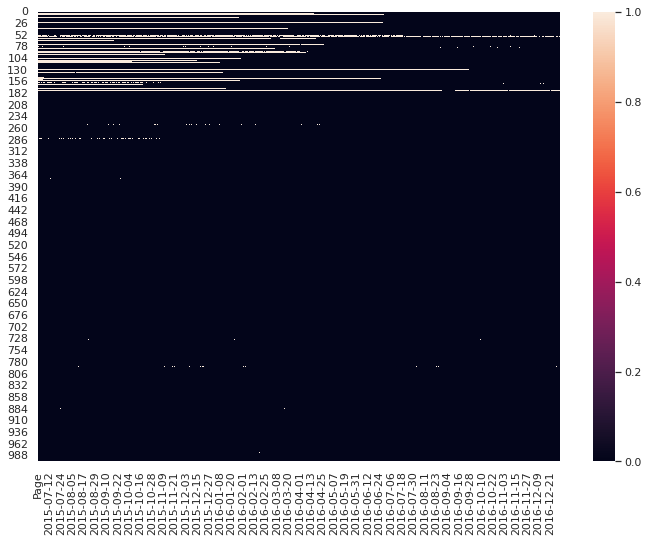

In [ ]:
import seaborn as sbn
sbn.heatmap(train.head(1000).isna())

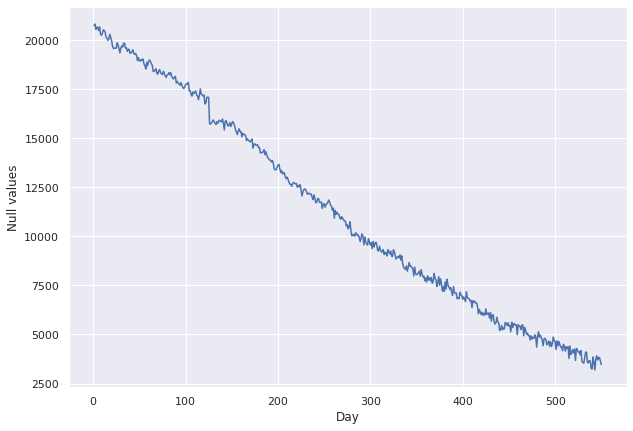

In [ ]:

days = [r for r in range(1, len(train.columns))]
plot.figure(figsize=(10,7))
plot.xlabel('Day')
plot.ylabel('Null values')
plot.plot(days, train.isnull().sum()[1:])

We see that the number of nan values decrease with time.

Probable reason: Some website have all nan values in the begining, that can be due to the fact that those were created after that time so there is no traffic reading for that time 

In [ ]:
print(train.shape)
train=train.dropna(how='all')
#‘all’ : If all values are NA, drop that row or column.
print(train.shape)

train=train.dropna(thresh=300)
print(train.shape)


(145063, 551)
(145063, 551)
(133617, 551)


1. We try droping the rows that have all values as nan, none in our case.

2. We then also drop rows that have nan more than 300 days, because the time series for that would not make much sense

3. We fill all the remaining values with zero assuming there was no traffic on the date that the values are nan for.


In [ ]:
train=train.fillna(0)
train.tail()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
145012,Legión_(Marvel_Comics)_es.wikipedia.org_all-ac...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,7.0,3.0,2.0,4.0,2.0,4.0,4.0,1.0,2.0,2.0
145013,Referéndum_sobre_la_permanencia_del_Reino_Unid...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,9.0,16.0,8.0,3.0,6.0,3.0,3.0,10.0,11.0,3.0
145014,Salida_del_Reino_Unido_de_la_Unión_Europea_es....,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,29.0,36.0,23.0,182.0,43.0,8.0,22.0,13.0,18.0,14.0
145015,"Amar,_después_de_amar_es.wikipedia.org_all-acc...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,7.0,30.0,27.0,14.0,8.0,7.0,5.0,43.0,12.0,25.0
145016,Anexo:89.º_Premios_Óscar_es.wikipedia.org_all-...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0


# ***EDA***

 The page values are in this format


 **SPECIFIC NAME _ LANGUAGE.wikipedia.org _ ACCESS TYPE _ ACCESS ORIGIN**

having information about page name, the main domain, device type used to access the page, and also the request origin(spider or browser agent)


In [ ]:
#train['langgg']=train['Page'].apply(lambda x: x[x.find('wikipedia')-3:x.find('wikipedia')-1 ])

In [ ]:
#Usage of Regex 
def split_page(page):
    w = re.split('_|\.', page)
    print(w)
    return ' '.join(w[:-5]), w[-5], w[-2], w[-1]

split_page('2NE1_zh.wikipedia.org_all-access_spider')



['2NE1', 'zh', 'wikipedia', 'org', 'all-access', 'spider']


('2NE1', 'zh', 'all-access', 'spider')

In [ ]:
def split_page(page):
  w = re.split('_|\.', page)
  return ' '.join(w[:-5]), w[-5], w[-2], w[-1]

li = list(train.Page.apply(lambda x: split_page(str(x))))
df = pd.DataFrame(li)
df.columns = ['Title', 'Language', 'Access_type','Access_origin']
df = pd.concat([train, df], axis = 1)

We split the page name and get that information joining it with a temporary database.
below we get some rows to see the structure of the data

In [ ]:
df.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31,Title,Language,Access_type,Access_origin
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,14.0,20.0,22.0,19.0,18.0,20.0,2NE1,zh,all-access,spider
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,9.0,30.0,52.0,45.0,26.0,20.0,2PM,zh,all-access,spider
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,4.0,4.0,6.0,3.0,4.0,17.0,3C,zh,all-access,spider
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,16.0,11.0,17.0,19.0,10.0,11.0,4minute,zh,all-access,spider
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,5566,zh,all-access,spider


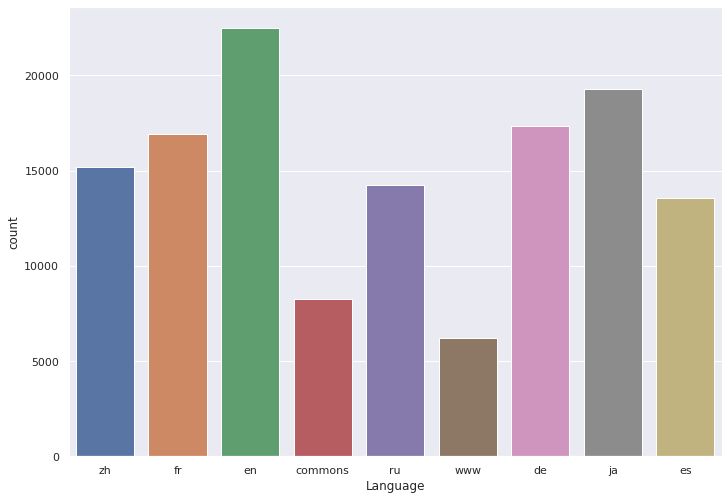

In [ ]:
sns.countplot(df['Language'])

This above is the comparision number of articles in each language

{'ja':'Japanese', 'de':'German',  'en' : 'English',  'no_lang':'Media_File',  'fr':'French',  'zh':'Chinese',  'ru':'Russian',  'es':'Spanish'}

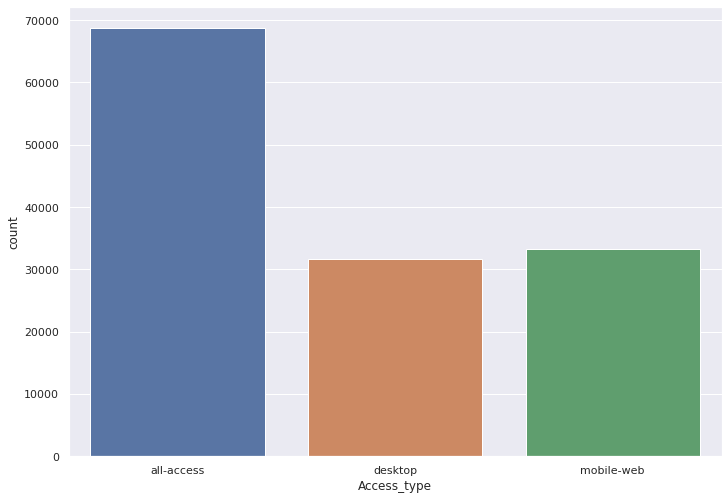

In [ ]:
sns.countplot(df['Access_type'])

This comparision shows that usage from desktop and mobile is almost the same

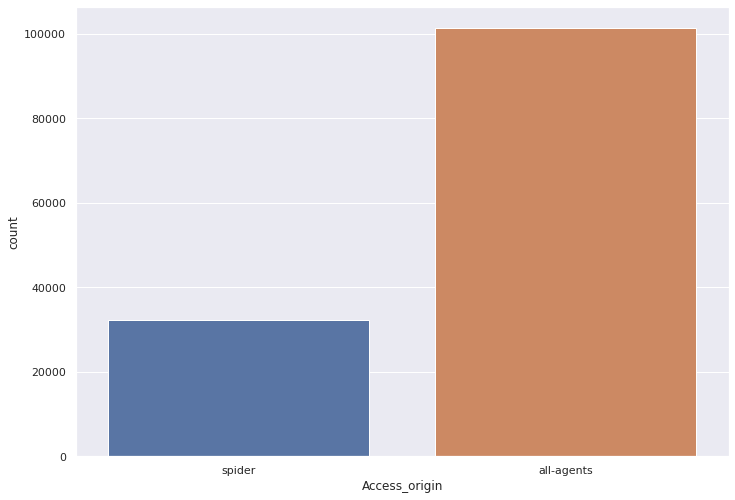

In [ ]:
sns.countplot(df['Access_origin'])

This shows that organic view is far more than that of spiders or bots

**Now we want to compare the views for different languages **

In [ ]:
#here we see that the languages are not treated properly as there are commons and www
df.groupby('Language').count()  

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31,Title,Access_type,Access_origin
Language,,,,,,,,,,,,,,,,,,,,,
commons,7672,7672,7672,7672,7672,7672,7672,7672,7672,7672,...,7672,7672,7672,7672,7672,7672,7672,8266,8266,8266
de,15946,15946,15946,15946,15946,15946,15946,15946,15946,15946,...,15946,15946,15946,15946,15946,15946,15946,17362,17362,17362
en,20758,20758,20758,20758,20758,20758,20758,20758,20758,20758,...,20758,20758,20758,20758,20758,20758,20758,22486,22486,22486
es,12268,12268,12268,12268,12268,12268,12268,12268,12268,12268,...,12268,12268,12268,12268,12268,12268,12268,13551,13551,13551
fr,15418,15418,15418,15418,15418,15418,15418,15418,15418,15418,...,15418,15418,15418,15418,15418,15418,15418,16948,16948,16948
ja,17132,17132,17132,17132,17132,17132,17132,17132,17132,17132,...,17132,17132,17132,17132,17132,17132,17132,19295,19295,19295
ru,12955,12955,12955,12955,12955,12955,12955,12955,12955,12955,...,12955,12955,12955,12955,12955,12955,12955,14270,14270,14270
www,5743,5743,5743,5743,5743,5743,5743,5743,5743,5743,...,5743,5743,5743,5743,5743,5743,5743,6228,6228,6228
zh,14845,14845,14845,14845,14845,14845,14845,14845,14845,14845,...,14845,14845,14845,14845,14845,14845,14845,15211,15211,15211


In [ ]:
df[df['Language']=='commons']

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31,Title,Language,Access_type,Access_origin
12271,Burning_Man_en.wikipedia.org_desktop_all-agents,1693.0,1490.0,1186.0,1099.0,1051.0,1968.0,1874.0,1637.0,1842.0,...,940.0,2976.0,2447.0,1648.0,1282.0,956.0,Accueil,commons,all-access,spider
12272,Cali_Cartel_en.wikipedia.org_desktop_all-agents,348.0,363.0,214.0,252.0,257.0,320.0,340.0,345.0,432.0,...,1197.0,1449.0,1376.0,1350.0,1287.0,992.0,Atlas of Asia,commons,all-access,spider
12273,Call_of_Duty:_Modern_Warfare_2_en.wikipedia.or...,806.0,768.0,700.0,725.0,723.0,823.0,849.0,731.0,833.0,...,818.0,929.0,892.0,878.0,893.0,712.0,Atlas of Europe,commons,all-access,spider
12274,Calvin_Harris_en.wikipedia.org_desktop_all-agents,7114.0,5599.0,7685.0,15844.0,9390.0,7173.0,5499.0,6367.0,5630.0,...,1242.0,1409.0,1714.0,1604.0,1602.0,1300.0,Atlas of World War II,commons,all-access,spider
12275,Carl_Sagan_en.wikipedia.org_desktop_all-agents,1808.0,1759.0,1838.0,1631.0,1701.0,2230.0,2052.0,2065.0,2002.0,...,1425.0,1730.0,1858.0,1781.0,1718.0,1345.0,Atlas of colonialism,commons,all-access,spider
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75274,Ash_Wednesday_en.wikipedia.org_mobile-web_all-...,170.0,169.0,165.0,166.0,186.0,154.0,154.0,184.0,173.0,...,475.0,444.0,389.0,382.0,362.0,393.0,"File:El jardín de las Delicias, de El Bosco jpg",commons,desktop,all-agents
75275,Ashley_Williams_(footballer)_en.wikipedia.org_...,112.0,102.0,135.0,147.0,120.0,89.0,90.0,109.0,215.0,...,348.0,439.0,357.0,267.0,639.0,429.0,File:Jää on kulmunud pallideks (Looduse veidru...,commons,desktop,all-agents
75276,Assassin's_Creed_(film)_en.wikipedia.org_mobil...,28.0,15.0,24.0,24.0,27.0,34.0,36.0,35.0,22.0,...,43471.0,41147.0,38978.0,36517.0,41760.0,38116.0,File:Reichstagsgebäude mit Weihnachtsbaum bei ...,commons,desktop,all-agents
75277,Aubrey_Plaza_en.wikipedia.org_mobile-web_all-a...,3067.0,2952.0,3459.0,3310.0,3294.0,3885.0,3830.0,3325.0,3150.0,...,4004.0,4848.0,5125.0,4907.0,4617.0,4415.0,Category:Images by Eugène Cattin,commons,desktop,all-agents


In [ ]:
# Checking another way of fetching the language out of the string
def lang(Page):
    val = re.search('[a-z][a-z].wikipedia.org',Page)
    if val:
        #print(val)
        #print(val[0][0:2] )
  
        return val[0][0:2]           
    
    return 'no_lang'

df['Language']=df['Page'].apply(lambda x: lang(str(x)))

In [ ]:
df.groupby('Language').count() #now the count has increased. You can go back and get it sorted

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31,Title,Access_type,Access_origin
Language,,,,,,,,,,,,,,,,,,,,,
de,17362,17362,17362,17362,17362,17362,17362,17362,17362,17362,...,17362,17362,17362,17362,17362,17362,17362,13046,13046,13046
en,22486,22486,22486,22486,22486,22486,22486,22486,22486,22486,...,22486,22486,22486,22486,22486,22486,22486,22486,22486,22486
es,13551,13551,13551,13551,13551,13551,13551,13551,13551,13551,...,13551,13551,13551,13551,13551,13551,13551,10142,10142,10142
fr,16948,16948,16948,16948,16948,16948,16948,16948,16948,16948,...,16948,16948,16948,16948,16948,16948,16948,16948,16948,16948
ja,19295,19295,19295,19295,19295,19295,19295,19295,19295,19295,...,19295,19295,19295,19295,19295,19295,19295,16140,16140,16140
no_lang,14494,14494,14494,14494,14494,14494,14494,14494,14494,14494,...,14494,14494,14494,14494,14494,14494,14494,25374,25374,25374
ru,14270,14270,14270,14270,14270,14270,14270,14270,14270,14270,...,14270,14270,14270,14270,14270,14270,14270,14270,14270,14270
zh,15211,15211,15211,15211,15211,15211,15211,15211,15211,15211,...,15211,15211,15211,15211,15211,15211,15211,15211,15211,15211


In [ ]:
df_language=df.groupby('Language').mean().transpose()
df_language

Language,de,en,es,fr,ja,no_lang,ru,zh
2015-07-01,763.765926,3767.328604,1127.485204,499.092872,614.637160,102.733545,663.199229,272.498521
2015-07-02,753.362861,3755.158765,1077.485425,502.297852,705.813216,107.663447,674.677015,272.906778
2015-07-03,723.074415,3565.225696,990.895949,483.007553,637.451671,101.769629,625.329783,271.097167
2015-07-04,663.537323,3711.782932,930.303151,516.275785,800.897435,86.853871,588.171829,273.712379
2015-07-05,771.358657,3833.433025,1011.759575,506.871666,768.352319,96.254105,626.385354,291.977713
...,...,...,...,...,...,...,...,...
2016-12-27,1119.596936,6314.335275,1070.923400,840.590217,808.541436,155.270181,998.374071,363.066991
2016-12-28,1062.284069,6108.874144,1108.996753,783.585379,807.430163,178.561267,945.054730,369.049701
2016-12-29,1033.939062,6518.058525,1058.660320,763.209169,883.752786,150.873534,909.352207,340.526330
2016-12-30,981.786430,5401.792360,807.551177,710.502773,979.278777,156.049193,815.475123,342.745316


In [ ]:
df_language.reset_index(inplace=True)
df_language.set_index('index', inplace=True)

Text(0, 0.5, 'Views per Page')

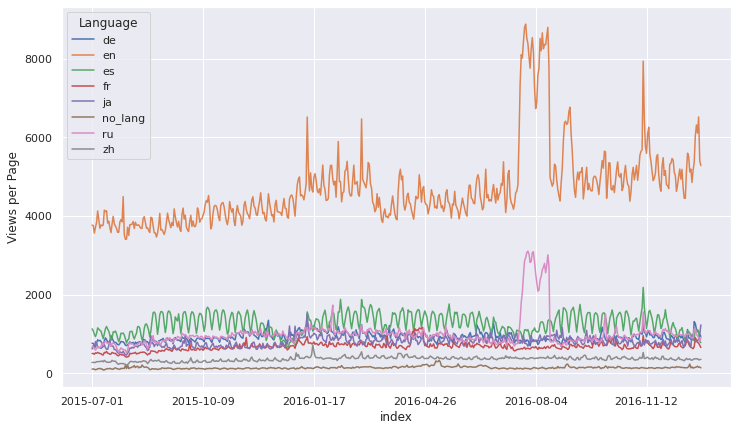

In [ ]:
df_language.plot(figsize=(12,7))
plot.ylabel('Views per Page')

Ploting the data shows that articles in english get the most number of views as compared to different languages, there are some spikes at different times in different laguages

Ploting just for english because we are going to use this for our furthur investigation and predictions

Text(0, 0.5, 'Views per Page')

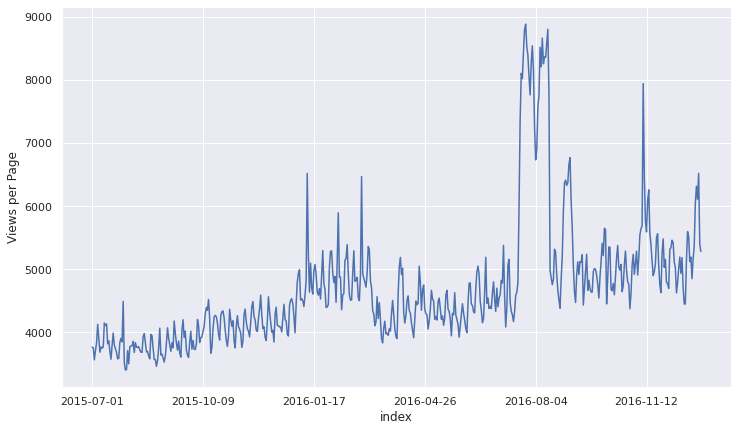

In [ ]:
df_language['en'].plot(figsize=(12,7))
plot.ylabel('Views per Page')

In [ ]:
total_view=df_language.copy()

# Checking the stationarity 

Dickey-Fuller test

**Here the null hypothesis is that the TS is non-stationary**: 
The test results comprise of a Test Statistic and some Critical Values for difference confidence levels.


In [ ]:
from statsmodels.tsa.stattools import adfuller
def df_test(x):
    result=adfuller(x)
    print('ADF Stastistic: %f'%result[0])
    print('p-value: %f'%result[1])

df_test(total_view['en'])

ADF Stastistic: -2.373563
p-value: 0.149337


We see that the p value is not low enough(<0.05). Therefore, we can say our series in not stationary as we fail to reject the null hypothesis

# Making the time series stationary


In [ ]:
ts=total_view['en']

## 1. Remove trend and seasonality with decomposition

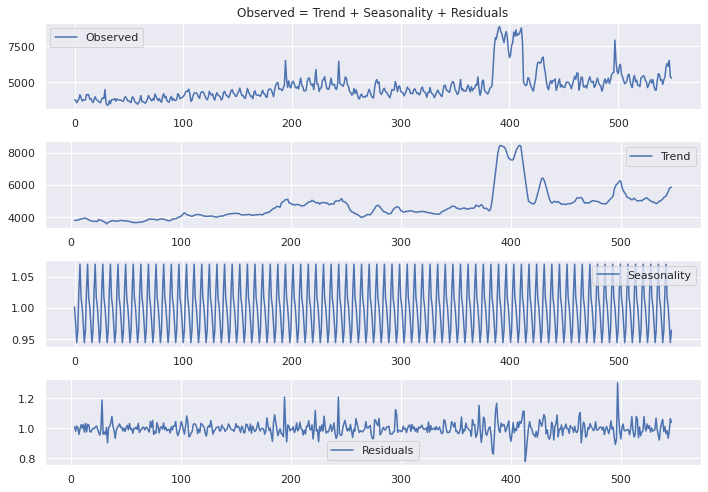

In [ ]:
# Naive decomposition of our Time Series as explained above
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts.values, model='multiplicative',freq = 7)


trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plot.figure(figsize=(10,7))
plot.subplot(411)
plot.title('Observed = Trend + Seasonality + Residuals')
plot.plot(ts.values,label='Observed')
plot.legend(loc='best')
plot.subplot(412)
plot.plot(trend, label='Trend')
plot.legend(loc='best')
plot.subplot(413)
plot.plot(seasonal,label='Seasonality')
plot.legend(loc='best')
plot.subplot(414)
plot.plot(residual, label='Residuals')
plot.legend(loc='best')
plot.tight_layout()
plot.show()

In [ ]:
ts_decompose=pd.DataFrame(residual).fillna(0)[0].values
df_test(ts_decompose)

ADF Stastistic: -3.796320
p-value: 0.002945


We can see that our series is now stationary, we can also try diffrencing to see what results we can get.

# 2. Remove trend and seasonality with differencing


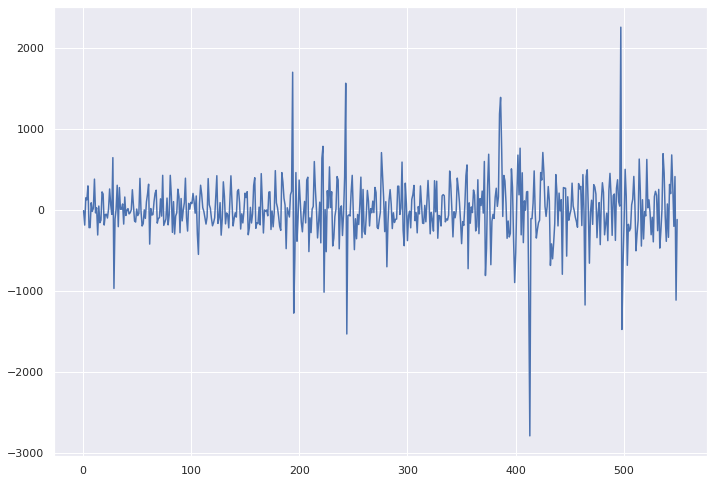

In [ ]:
ts_diff = ts - ts.shift(1)
plot.plot(ts_diff.values)
plot.show()

In [ ]:
ts_diff.dropna(inplace=True)
df_test(ts_diff)

ADF Stastistic: -8.273590
p-value: 0.000000


 Also the p value is 0. So we can say that our graph is now stationery.
Now we can apply the ARIMA model

**How do we choose p,d,q**

a thumb rule that for choosing the p,q values are when the lag goes below the significant level
- we use PACF for p, here we see that till lag 5 there are significat lines, if we want our model to be simpler we can start with a smaller number like 3/4
- we use ACF for q. here we can see that lag 4 is below significant level so we will use till lag 3


as for d we can see that at 1 diffencing the series becomes stationary so we choose d as 1

# Plot the autocorreltaion and partial auto correlation functions

Plotting the graphs and getting the p,q,d values for arima

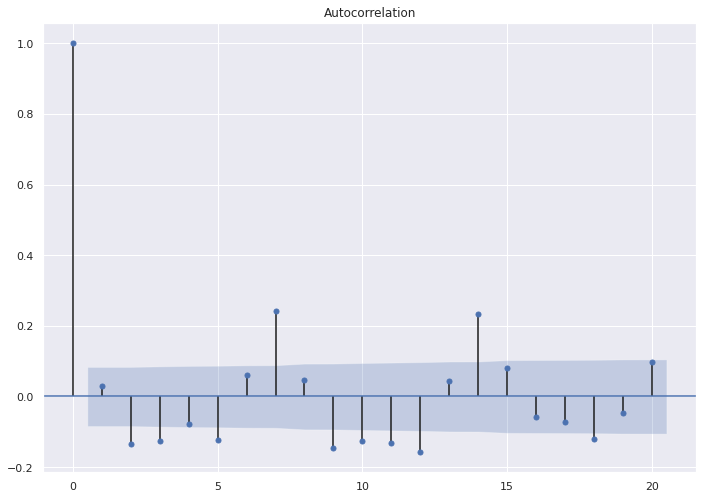

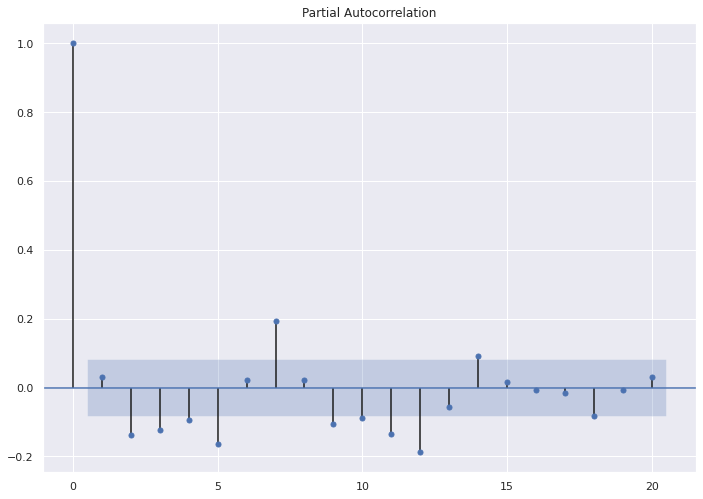

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
acf=plot_acf(ts_diff,lags=20)
pacf=plot_pacf(ts_diff,lags=20)

# ARIMA MODEL

In [ ]:
model = ARIMA(ts, order=(4,1,3))
model_fit = model.fit(disp=0)


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


**Multistep forecasting**

In [ ]:
train = ts[:-20]
test = ts[-20:]

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


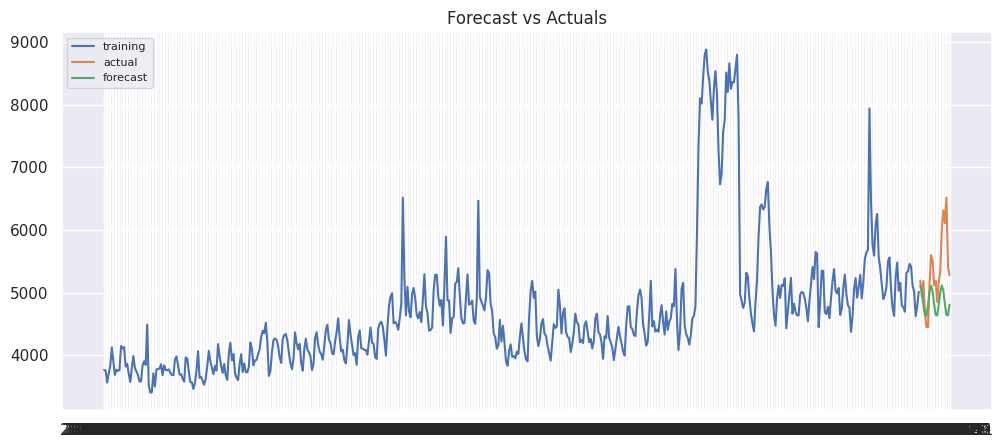

In [ ]:
model = ARIMA(train, order=(4, 1, 3))  
fitted = model.fit(disp=-1)  

# Forecast
fc, se, conf = fitted.forecast(20, alpha=0.02)  

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
# Plot
plot.figure(figsize=(12,5), dpi=100)
plot.plot(train, label='training')
plot.plot(test, label='actual')
plot.plot(fc_series, label='forecast')

plot.title('Forecast vs Actuals')
plot.legend(loc='upper left', fontsize=8)

In [ ]:
mape = np.mean(np.abs(fc - test.values)/np.abs(test.values))
rmse = np.mean((fc - test.values)**2)**.5
print("mape:",mape)
print("rsme:",rmse)

mape: 0.0935492560101219
rsme: 706.602453194038


we can see that the model does not perform very well for multistep out sample data

from the decomposition we can see that there is a weekly seasonality and still some spikes in the residual, that may be because of some external factors, which we can take into account by using them as our exogenous variable

In [ ]:
ex_df = pd.read_csv('Exog_Campaign_eng')
ex_df.head()

,Exog
0,0
1,0
2,0
3,0
4,0


We get the exogenous data from this csv file for english pages

In [ ]:
exog=ex_df['Exog'].to_numpy()


we will train a sarimax model for that and see if we get anyimprovements from using the two information.

the seasonal order and the values of PDQ are based upon various trials and comparision of the models
- we see a seasonality of 7 from the plots ie: weekly seasonality ( from the plots we can see that afte some insignificant plots we have some significant values repeating at intervals of 7 ie: 7,14 ... )
- the non seasonal order we can keep the same

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


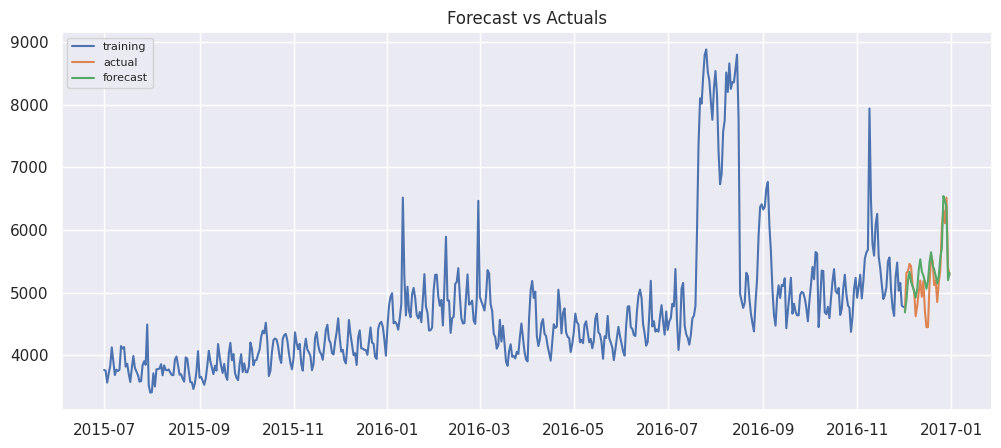

In [ ]:
import statsmodels.api as sm
train=ts[:520]
test=ts[520:]
model=sm.tsa.statespace.SARIMAX(train,order=(4, 1, 3),seasonal_order=(1,1,1,7),exog=exog[:520])
results=model.fit()

fc=results.forecast(30,dynamic=True,exog=pd.DataFrame(exog[520:]))

# Make as pandas series
fc_series = pd.Series(fc)
# Plot
train.index=train.index.astype('datetime64[ns]')
test.index=test.index.astype('datetime64[ns]')
plot.figure(figsize=(12,5), dpi=100)
plot.plot(train, label='training')
plot.plot(test, label='actual')
plot.plot(fc_series, label='forecast')

plot.title('Forecast vs Actuals')
plot.legend(loc='upper left', fontsize=8)

In [ ]:
mape = np.mean(np.abs(fc - test.values)/np.abs(test.values))
rmse = np.mean((fc - test.values)**2)**.5
print("mape:",mape)
print("rsme:",rmse)

mape: 0.0476009066291969
rsme: 299.17343793278815


The mean absolute percentage error and the root mean squared error is low 

# regression for a time series

In [ ]:
ts_df=ts.to_frame()
ts_df.head()

,en
index,
2015-07-01,3767.328604
2015-07-02,3755.158765
2015-07-03,3565.225696
2015-07-04,3711.782932
2015-07-05,3833.433025


In [ ]:
ts_df.reset_index(level=0, inplace=True)
ts_df['date']=pd.to_datetime(ts_df['index'])
ts_df.drop(['index'],axis=1,inplace=True)
ts_df.head()

,en,date
0,3767.328604,2015-07-01
1,3755.158765,2015-07-02
2,3565.225696,2015-07-03
3,3711.782932,2015-07-04
4,3833.433025,2015-07-05


In [ ]:
ts_df['day_of_week']=ts_df['date'].dt.day_name()
ts_df.head()


,en,date,day_of_week
0,3767.328604,2015-07-01,Wednesday
1,3755.158765,2015-07-02,Thursday
2,3565.225696,2015-07-03,Friday
3,3711.782932,2015-07-04,Saturday
4,3833.433025,2015-07-05,Sunday


In [ ]:
ts_df=pd.get_dummies(ts_df, columns = ['day_of_week'])

In [ ]:
ts_df.head()

,en,date,day_of_week_Friday,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday
0,3767.328604,2015-07-01,0,0,0,0,0,0,1
1,3755.158765,2015-07-02,0,0,0,0,1,0,0
2,3565.225696,2015-07-03,1,0,0,0,0,0,0
3,3711.782932,2015-07-04,0,0,1,0,0,0,0
4,3833.433025,2015-07-05,0,0,0,1,0,0,0


In [ ]:
ts_df['exog']=ex_df['Exog']
ts_df['rolling_mean']=ts_df['en'].rolling(7).mean()

In [ ]:
ts_df=ts_df.dropna()
ts_df.head()


,en,date,day_of_week_Friday,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday,exog,rolling_mean
6,3906.341724,2015-07-07,0,0,0,0,0,1,0,0,3809.528545
7,3685.854621,2015-07-08,0,0,0,0,0,0,1,0,3797.889404
8,3771.183714,2015-07-09,0,0,0,0,1,0,0,0,3800.178683
9,3749.860313,2015-07-10,1,0,0,0,0,0,0,0,3826.555056
10,3770.749355,2015-07-11,0,0,1,0,0,0,0,0,3834.978831


In [ ]:
X=ts_df[['day_of_week_Friday',	'day_of_week_Monday',	'day_of_week_Saturday',	'day_of_week_Sunday',	'day_of_week_Thursday',	'day_of_week_Tuesday',	'day_of_week_Wednesday',	'exog',	'rolling_mean']].copy()
y=ts_df[['en']]

train_x = X[:-20]
test_x = X[-20:]

train_y = y[:-20]
test_y = y[-20:]


In [ ]:
from sklearn.linear_model import LinearRegression

# Train and pred
model = LinearRegression()
model.fit(train_x, train_y)
y_pred = (model.predict(test_x))


mape = np.mean(np.abs(y_pred - test_y.values)/np.abs(test_y.values))
print("mape:",mape)


mape: 0.04523968736329716


We can see here that aur mape is better than our arima model but worse than our sarimax model

# using Facebook Prophet

In [ ]:
ts_df['ds']=ts_df['date']
ts_df['y']=ts_df['en']

In [ ]:
df2=ts_df[['date','en','exog']].copy()
df2.columns = ['ds', 'y', 'exog']
df2.head()

,ds,y,exog
6,2015-07-07,3906.341724,0
7,2015-07-08,3685.854621,0
8,2015-07-09,3771.183714,0
9,2015-07-10,3749.860313,0
10,2015-07-11,3770.749355,0


In [ ]:
df2[:-20].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 524 entries, 6 to 529
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      524 non-null    datetime64[ns]
 1   y       524 non-null    float64       
 2   exog    524 non-null    int64         
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 16.4 KB


prophet without exogenous

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


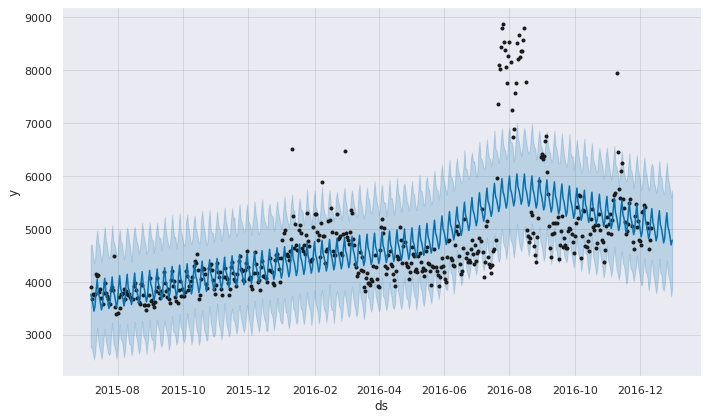

In [ ]:
m = Prophet(weekly_seasonality=True)
m.fit(df2[['ds', 'y']][:-20]) 
future = m.make_future_dataframe(periods=20,freq="D")
forecast = m.predict(future)
fig = m.plot(forecast)

prophet with exogenous

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


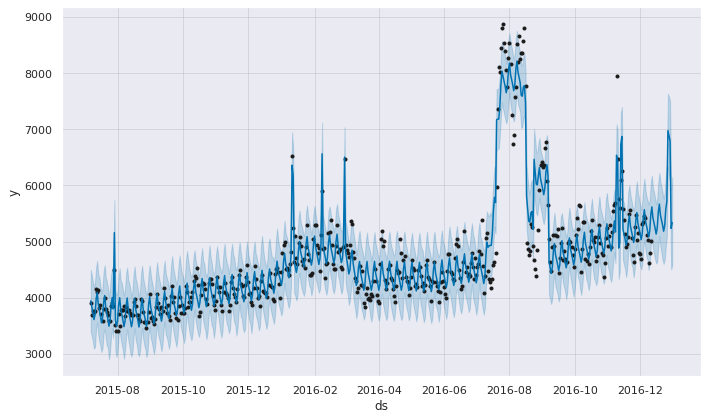

In [ ]:
model2=Prophet(interval_width=0.9, weekly_seasonality=True, changepoint_prior_scale=1)
model2.add_regressor('exog') 
model2.fit(df2[:-20])
forecast2 = model2.predict(df2)
fig = model2.plot(forecast2)

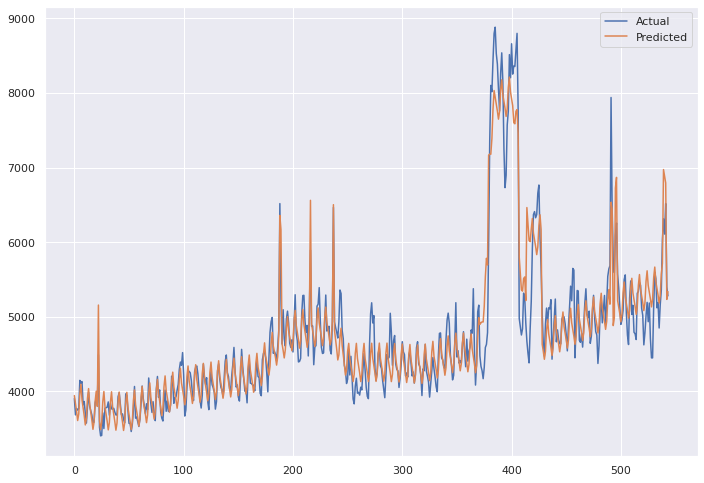

In [ ]:
y_true = df2['y'].values
y_pred = forecast2['yhat'].values

plot.plot(y_true, label='Actual')
plot.plot(y_pred, label='Predicted')
plot.legend()
plot.show()

In [ ]:

mape = np.mean(np.abs(forecast2['yhat'][-20:] - df2['y'][-20:].values)/np.abs(df2['y'][-20:].values))
print("mape:",mape)

mape: 0.06592815614410931
